In [27]:
from glob import glob
import uproot as ur
import numpy as np
import json, os
import os.path as osp
from tqdm.auto import tqdm
from typing import Optional
from json import load
from phc import module_reload, plot_hist
module_reload('zhh')
from zhh import parse_sample_path, get_preselection_passes, ProcessIndex, \
    get_chunks_factual, EventCategories, sample_weight, presel_stack, \
    parse_json, get_pol_key, get_final_state_counts, fig_ild_style, \
    get_process_normalization, plot_preselection_by_event_category, \
    plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, \
    calc_preselection_by_processes
from zhh.plot.plot_preselection import plot_preselection_by_calc_dict
version = 'v1'

REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH' if os.name != 'nt' else 'C:/DevRepositories/ZHH'
DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh' if os.name != 'nt' else f'{REPO_ROOT}/DATA_ROOT'
INDEX_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreateRawIndex/v1'

processes = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/processes.npy")
samples = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/samples.npy")
chunks = np.load(f'{DATA_ROOT}/CreatePreselectionChunks/v1/chunks.npy') if os.name != 'nt' else np.load(f'{REPO_ROOT}/chunks_f.npy')

Preselection Detailed

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
category_map = { key:value for key, value in EventCategories.EVENT_CATEGORY_TRUE.__dict__.items() if not key.startswith('__') and not callable(key)}
category_map_inv = { v: k for k, v in category_map.items() }

category_arr = np.zeros(len(category_map_inv.keys()), dtype=[('evt_cat', 'I'), ('name', '<U16')])
category_arr['evt_cat'] = list(category_map_inv.keys())
category_arr['name'] = list(category_map_inv.values())

mode = 'prod'
save = False

if mode == 'prod':
    DATA_R = f'{DATA_ROOT}/PreselectionFinal/{version}'
    branches = [14336]
    presel = 'llHH'
elif mode == 'debug':
    DATA_R = f'{REPO_ROOT}/output'
    branches = ['zhh']
    presel = 'llHH'

#get_final_state_counts(DATA_R, branches, chunks_f)

In [29]:
module_reload('zhh')
from zhh import presel_stack
from typing import List, Optional, Generator

def iterate_chunks(files:List[str], mmap:bool=False)->Generator:
    for file in files:
        yield np.load(file, mmap_mode=(None if mmap else 'r'))

def join_chunks(size:int, files:List[str]):    
    result = None
    pointer = 0

    for file in tqdm(files):
        part = np.load(file)
        if result is None:
            result = np.zeros(size, dtype=part.dtype)
            
        result[pointer:(pointer+len(part))] = part
        pointer += len(part)
    
    return result

if mode == 'prod' or mode == 'prod-debug':
    if os.name != 'nt':
        chunks_f = get_chunks_factual(f'{DATA_ROOT}/PreselectionFinal/{version}', chunks_in=chunks)
    else:
        chunks_f = chunks

if mode == 'prod-debug':
    # create PreselectionSummary results here
    presel_results = presel_stack(f'{DATA_ROOT}/PreselectionFinal/{version}', processes, chunks_f, [0,1])#chunks['branch'])
elif mode == 'prod':
    # use PreselectionSummary results
    size = chunks_f['chunk_size_factual'].sum()
    
    presel_results = join_chunks(size, glob(f'{DATA_ROOT}/PreselectionSummary/v1/[0-9]*_Presel.npy'))
    presel_fsc = join_chunks(size, glob(f'{DATA_ROOT}/PreselectionSummary/v1/[0-9]*_FinalStates.npy'))
    
elif mode == 'debug':
    branch = 'zhh'
    meta = parse_json(f'{REPO_ROOT}/output/{branch}_FinalStateMeta.json')
    
    chunks_f_deb = np.zeros(1, dtype=[('branch', f'<U{len(branch)}'), ('proc_pol', '<U32'), ('chunk_size_factual', 'I')])
    chunks_f_deb['branch'] = 'zhh'
    chunks_f_deb['proc_pol'] = f"{meta['processName']}_{get_pol_key(meta['polElectron'], meta['polPositron'])}"
    chunks_f_deb['chunk_size_factual'] = meta['nEvtSum']
    
    presel_results = presel_stack(f'{REPO_ROOT}/output', processes, chunks_f_deb, [branch], kinematics=True)
elif mode == 'load':
    presel_results = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_results.npy')

if mode != 'load':
    # Calculate weights
    pids = np.unique(presel_results['pid'])
    weights = np.zeros(len(pids), dtype=[('pid', 'H'), ('weight', 'f')])
    weights['pid'] = pids

    for pid in tqdm(pids):
        process = processes[processes['pid'] == pid][0]
        pol_em, pol_ep = process['pol_e'], process['pol_p']
        cross_sec = process['cross_sec']
        
        n_gen = np.sum(presel_results['pid'] == pid)
        
        weights['weight'][weights['pid'] == pid] = sample_weight(cross_sec, (pol_em, pol_ep), n_gen)
else:
    weights = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_weights.npy')
    chunks_f = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy')
    
if save == True:
    np.save(f'{DATA_ROOT}/presel_results.npy', presel_results)
    np.save(f'{DATA_ROOT}/presel_weights.npy', weights)
    np.save(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy', chunks_f)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [30]:
pn = get_process_normalization(processes, samples)
np.sum(pn['n_events_expected'][np.isin(pn['process'], ['e1e1hh', 'e2e2hh', 'e3e3hh'])])

41.167603

In [31]:
module_reload('phc')
module_reload('zhh')
from phc import plot_hist
from zhh import fig_ild_style, plot_preselection_by_event_categories

In [32]:
from typing import List, Union, Iterable
from matplotlib.figure import Figure

def plot_cut_efficiency(presel_results:np.ndarray, masks:List[np.ndarray], weights:np.ndarray, signal_categories:List[int],
                        category_map_inv:dict, processes:np.ndarray,
                        quantity:str, xunit:str, event_categories:Optional[List[int]]=None, additional_event_categories:int=2,
                        with_sbr:bool=True, previous_mask:Optional[np.ndarray]=None,
                        xlim:Optional[tuple]=None, yscale:str='log', nbins:Union[int,Iterable[int]]=100, ild_style_kwargs:dict={}, xlabel:Optional[str]=None)->List[Figure]:
    all_figs = []
    subsets = []
    for mask in masks:
        subsets.append(presel_results[mask])
    
    subset_pre = subsets[0]
    subset_end = subsets[-1]

    mask_pre_cat = np.isin(subset_pre['event_category'], signal_categories)
    mask_end_cat = np.isin(subset_end['event_category'], signal_categories)

    weights_pre  = weights['weight'][subset_pre[mask_pre_cat]['pid']]
    weights_post = weights['weight'][subset_end[mask_end_cat]['pid']]

    signal_eff = np.sum(weights_post)/np.sum(weights_pre)
    
    # Calculate relative signal efficiency
    signal_eff_relative = 0.
    if previous_mask is not None:
        subset_prev = presel_results[previous_mask]
        weights_prev  = weights['weight'][subset_prev[np.isin(subset_prev['event_category'], signal_categories)]['pid']]
        
        signal_eff_relative = np.sum(weights_post)/np.sum(weights_pre)
    
    if with_sbr:
        SBR_pre  = np.sum(weights_pre)/weights['weight'][subset_pre[~mask_pre_cat]['pid']].sum()
        SBR_end = np.sum(weights_post)/weights['weight'][subset_end[~mask_end_cat]['pid']].sum()
    
    for i, subset in enumerate([subset_pre, subset_end]):
        with_cuts = i > 0
        if with_cuts:
            title_postfix = r' $\bf{with}$ cuts @ ' + rf'${signal_eff*100:0.1f}{{%}}_{{abs}}$ eff.'
        else:
            title_postfix = r' $\bf{without}$ cuts'
        
        if with_sbr:
            title_postfix += rf'; SBR={(SBR_end if with_cuts else SBR_pre):.2E}'
        
        figs = plot_preselection_by_event_categories(subset, processes, weights, category_map_inv, 'llHH', True,
                                            categories_selected=event_categories,
                                            categories_additional=categories_additional,
                                        quantity=quantity, check_pass=False, plot_flat=False, unit=xunit, xlim=(xlim[i] if isinstance(xlim, list) else xlim),
                                        xlabel=quantity if xlabel is None else xlabel, yscale=yscale,
                                        ild_style_kwargs={
                                            'ild_offset_x': 0.55,
                                            'title_postfix': title_postfix
                                        } | ild_style_kwargs, nbins=(nbins[i] if isinstance(nbins, list) else nbins))
        for fig in figs:
            all_figs.append(fig)
        
        
        
    return all_figs

In [6]:
from matplotlib.figure import Figure
from typing import Generator

def generate_cuts_ll(presel_results:np.ndarray,
                     mH_lower:float=60., mH_upper:float=190.,
                     mZ:float=91.2, mZ_maxDiff:float=40.)->Generator[np.ndarray,np.ndarray,np.ndarray]:
    
    a = ( presel_results['xx_nisoleps'] >= 2 )
    yield a
    
    a = a & ( np.abs(presel_results['ll_mz'] - mZ) < mZ_maxDiff )
    yield a
    
    a = a & ( presel_results['ll_mh1'] < mH_upper ) & ( presel_results['ll_mh1'] > mH_lower )
    yield a
    
    a = a & ( presel_results['ll_mh2'] < mH_upper ) & ( presel_results['ll_mh2'] > mH_lower )
    yield a

def plot_lepton_preselection(presel_results:np.ndarray, weights:np.ndarray, category_map_inv:dict, processes:np.ndarray,
                             event_categories:List[int]=[11, 16, 12, 13, 14],ild_style_kwargs:dict={})->List[Figure]:
    all_figs = []
    
    signal_categories = [11]

    mask_start = np.ones(len(presel_results), dtype=bool) # (presel_results['ll_mz'] > 0)
    
    # n_isolep, mZ, mH1, mH2
    qoi = [
        ('xx_nisoleps', None, 'iso leptons', None, [6, 4]),
        ('ll_mz', 'GeV', 'm_Z', [(0, 650.), None], 100),
        ('ll_mh1', 'GeV', 'm_{H1}', [(0, 450.), None], [100, 32]),
        ('ll_mh2', 'GeV', 'm_{H2}', [(0, 450.), None], [100, 32]),
    ]
    
    for i, cut_mask in enumerate(generate_cuts_ll(presel_results)):
        quantity, xunit, xlabel, xlim, nbins = qoi[i]
        
        for fig in plot_cut_efficiency(presel_results, [mask_start, cut_mask], weights, signal_categories, category_map_inv, processes,
                                    quantity, xunit, event_categories=event_categories, xlabel=xlabel, nbins=nbins, xlim=xlim):
            all_figs.append(fig)
    
    return all_figs

In [44]:
plot_lepton_preselection(presel_results, weights, category_map_inv, processes)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

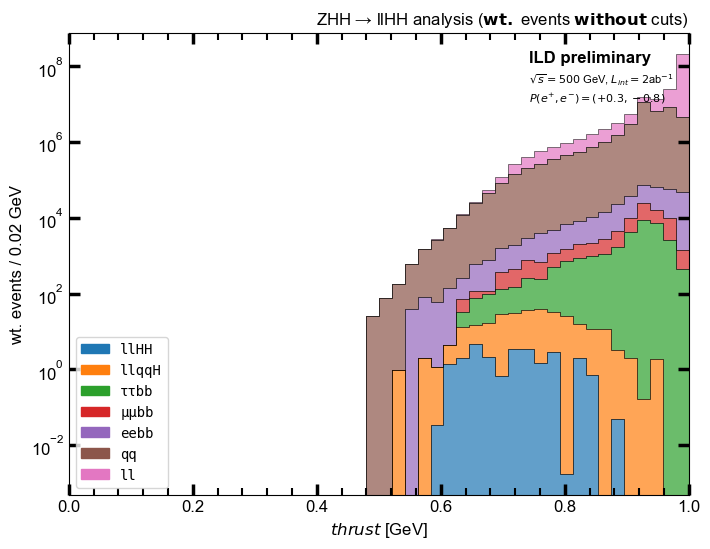

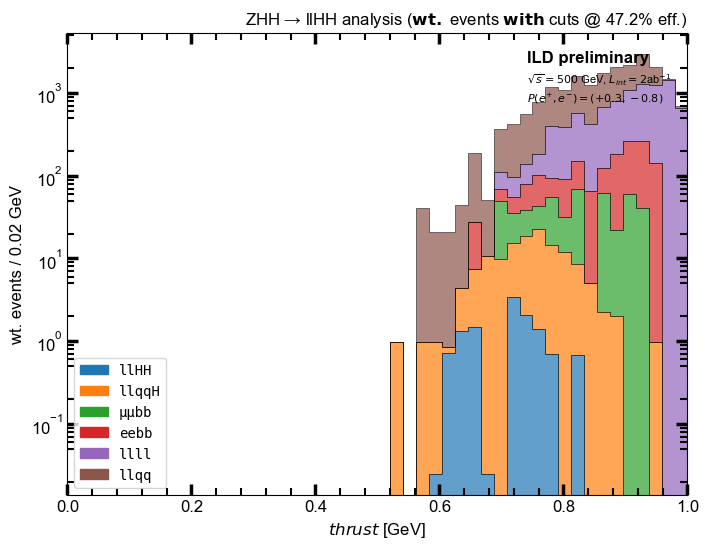

In [41]:
mH = 125
mZ = 91.2
mH_maxDiff = 60
mZ_maxDiff = 40

signal_categories = [11]

all_figs = []

mask_start = np.ones(len(presel_results), dtype=bool) # (presel_results['ll_mz'] > 0)
mask_end   = (presel_results['ll_mz'] > 0) & (presel_results['xx_nisoleps'] >= 2 ) & (np.abs(presel_results['ll_mz'] - mZ) < mZ_maxDiff) & \
        (np.abs(presel_results['ll_mh1'] - mH) < mH_maxDiff) & (np.abs(presel_results['ll_mh2'] - mH) < mH_maxDiff)
        
for fig in plot_cut_efficiency(presel_results, [mask_start, mask_end], weights, signal_categories, category_map_inv, processes,
                                'xx_thrust', 'GeV', event_categories=[11, 16, 12, 13, 14], xlabel='thrust', xlim=(0, 1.), nbins=48,
                                ild_style_kwargs={'legend_kwargs': { 'loc': 'lower left' }}, with_sbr=False):
    all_figs.append(fig)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not fo

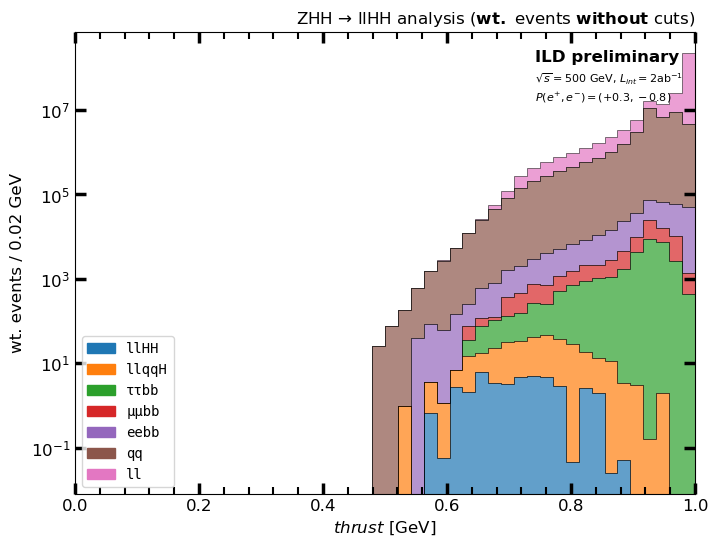

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


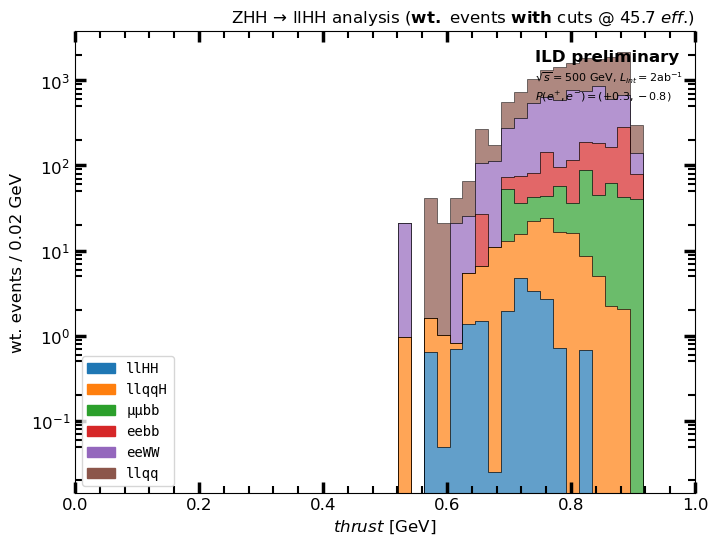

In [8]:
mH = 125
mZ = 91.2
mH_maxDiff = 65
mZ_maxDiff = 40

signal_categories = [11]

all_figs = []

mask_start = np.ones(len(presel_results), dtype=bool) # (presel_results['ll_mz'] > 0)
mask_end   =    (presel_results['ll_mz'] > 0) & \
                (presel_results['xx_nisoleps'] >= 2 ) & \
                (np.abs(presel_results['ll_mz'] - mZ) < mZ_maxDiff) & \
                ((presel_results['ll_mh1'] > 60) & (presel_results['ll_mh1'] < 180)) & \
                ((presel_results['ll_mh2'] > 60) & (presel_results['ll_mh2'] < 180)) & \
                (presel_results['xx_pt_miss'] < 70.) & \
                (presel_results['xx_thrust'] < 0.9)
        
for fig in plot_cut_efficiency(presel_results, [mask_start, mask_end], weights, signal_categories, category_map_inv, processes,
                                'xx_thrust', 'GeV', event_categories=[11, 16, 12, 13, 14], xlabel='thrust', xlim=(0, 1.), nbins=48,
                                ild_style_kwargs={'legend_kwargs': { 'loc': 'lower left' }}, with_sbr=False):
    all_figs.append(fig)

In [66]:
len(presel_results[presel_results['event_category'] == category_map['μvbbqq']])

722

In [67]:
a, b = np.unique(presel_results['pid'], return_counts=True)
c = weights['weight'][a] * b
c

array([1.55692835e+08, 1.01165664e+01, 1.30345821e+01, 3.03740390e+02,
       3.28689271e+07, 7.72149742e+00, 9.20892438e+04, 6.38948730e+03,
       1.36991606e+05, 3.79904859e+07, 1.83695471e+04, 4.24561799e+03,
       9.89131480e-01, 1.92398140e+05, 1.61091457e+07, 8.49153256e+06,
       3.11606621e+03, 2.63966243e+02, 3.50218677e+03, 2.70564652e+05,
       1.36770830e+05, 7.36520869e+04, 9.11642955e+06, 1.02014721e+04,
       7.80639965e+07, 9.08049968e+05, 4.97538318e+05, 8.98640691e+06,
       1.35631994e+05, 4.99333441e-01, 1.33549154e+01, 6.23360975e+03,
       1.44371574e+03, 9.59188187e+05, 6.22468616e+03, 2.03728008e+00,
       3.04878592e+06, 3.11732977e+03, 9.63522553e+01, 1.93607734e+05,
       3.77045465e+01, 1.18278814e+06, 2.75329018e+01, 1.34907215e+03,
       9.62741077e+01, 1.00407095e+04, 2.60004422e+03, 1.20858504e+05,
       2.29452211e+06, 7.12026899e+05, 1.11350657e+06, 1.71636306e-01,
       2.71000558e+05, 4.74434126e+05, 3.04140203e+05, 5.07329255e-01,
      

  0%|          | 0/9 [00:00<?, ?it/s]

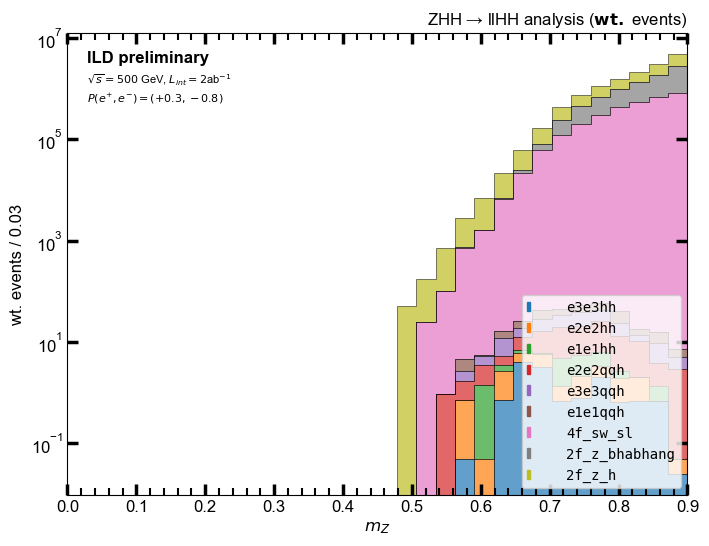

In [57]:
module_reload('zhh')
from zhh import calc_preselection_by_processes

subsec = presel_results
hypothesis = 'llHH'
xlabel = 'm_{Z}'
nbins = 32
xlim = (0, 0.9)

calc_dict = calc_preselection_by_processes(presel_results, processes, weights, quantity='xx_thrust',
                               processes_selected=['e1e1hh', 'e2e2hh', 'e3e3hh', 'e1e1qqh', 'e2e2qqh', 'e3e3qqh'], xlim=xlim,
                               processes_additional=3)

all_figs = plot_preselection_by_calc_dict(calc_dict[0], '', hypothesis, xlabel, nbins=nbins, xlim=xlim,
                                              title_label=rf'events', plot_flat=False, yscale='log',)

In [58]:
calc_dict

[{'2f_z_h': (array([0.7839339 , 0.8034369 , 0.8667291 , ..., 0.88941145, 0.7783308 ,
          0.8616604 ], dtype=float32),
   array([25.356184, 25.356184, 25.356184, ..., 20.099072, 20.099072,
          20.099072], dtype=float32)),
  '2f_z_bhabhang': (array([0.8905447 , 0.8912823 , 0.8771799 , ..., 0.84114   , 0.8669137 ,
          0.81798494], dtype=float32),
   array([26.31561, 26.31561, 26.31561, ..., 20.09945, 20.09945, 20.09945],
         dtype=float32)),
  '4f_sw_sl': (array([0.81444687, 0.77135843, 0.78171575, ..., 0.8510869 , 0.8700734 ,
          0.76527864], dtype=float32),
   array([24.879707, 24.879707, 24.879707, ..., 24.879707, 24.879707,
          24.879707], dtype=float32)),
  'e1e1qqh': (array([0.81975746, 0.7854587 , 0.7371474 , 0.70190793, 0.79681903,
          0.7832649 , 0.76043177, 0.8546718 , 0.78149825, 0.78954846,
          0.7966038 , 0.6604449 , 0.8060497 , 0.8419527 , 0.69768643,
          0.8762704 , 0.7848629 , 0.8177316 , 0.8740991 , 0.72535115,
        

In [68]:
for key in calc_dict[0]:
    val = calc_dict[0][key]
    print(key, np.dot(val[0], val[1]))

2f_z_bhabhang 619129700.0
4f_sze_l 107693070.0
2f_z_bhabhag 162108580.0
e2e2qqh 7500.666
e1e1qqh 6688.135
e1e1hh 1081.13
e2e2hh 1039.3379
e3e3qqh 116.49232
e3e3hh 79.181984


In [148]:
from phc import module_reload
module_reload('zhh')
from zhh import calc_preselection_by_processes
from zhh.analysis.PreselectionAnalysis import w_em_ep, w_prefacs, combined_cross_section
from zhh.analysis.ZHHCuts import zhh_cuts
from zhh.analysis.Cuts import Cut, EqualCut
from typing import List, Generator
from tabulate import tabulate
import numpy as np

def apply_cuts(data:np.ndarray, cuts:List[Cut], consecutive:bool=True)->Generator:
    for i, cut in enumerate(cuts):
        if consecutive:
            if i == 0:
                a = cut(data)
            else:
                a = a & cut(data)
            
            yield a, cut
        else:
            yield cut(data), cut

In [156]:
result

{'2f_z_bhabhag': (None,
  array([20.09939, 20.09939, 20.09939, 20.09939, 20.09939, 20.09939,
         20.09939, 20.09939, 20.09939], dtype=float32)),
 'xxvelv': (None, array([], dtype=float32)),
 'xxveev': (None, array([], dtype=float32)),
 'vvxyyx': (None, array([], dtype=float32)),
 'vvxylv': (None, array([], dtype=float32)),
 'vvxyev': (None, array([], dtype=float32)),
 'e1e1hh': (None, array([], dtype=float32)),
 'e3e3hh': (None, array([], dtype=float32)),
 'e2e2hh': (None, array([], dtype=float32))}

In [194]:
signal_processes = [
    ['e1e1hh', 'e2e2hh', 'e3e3hh'],
    ['n1n1hh', 'n23n23hh'],
    ['qqhh']
]
luminosity_inv_ab = 2
format_cross_section = lambda cross_sec: f'{cross_sec:2E}'
format_expected_events = lambda cross_sec: f'{(cross_sec * luminosity_inv_ab * 1e3):2E}'

#for j, hypothesis in enumerate(['llHH', 'vvHH', 'qqHH']):
#   print(hypothesis)

signal_proc = signal_processes[j]
background_proc = list(set(np.unique(chunks_f['process'])) - set(signal_proc))

hypothesis = 'llHH'
j = 0

subset = presel_results

if True:
    *_, last = apply_cuts(subset, zhh_cuts(hypothesis))
    mask, cat = last
else:
    mask = subset[f'{hypothesis[:2]}_pass'] == 1

result = calc_preselection_by_processes(subset[mask], processes, weights,
                               processes_selected=signal_processes[j],
                               processes_additional=6)[0]

header = []
rows = []

cross_sections = []
expected_events = []

for process in list(set(result.keys()) - set(signal_proc)):
    header.append(process)
    cross_sec = combined_cross_section(processes, process)
    
    cross_sections.append(format_cross_section(cross_sec))
    expected_events.append(format_expected_events(cross_sec))

# Background
bkg_cross_sec = combined_cross_section(processes, background_proc)
header.append('Background')
cross_sections.append(format_cross_section(bkg_cross_sec))
expected_events.append(format_expected_events(bkg_cross_sec))

# Signal
sig_cross_sec = combined_cross_section(processes, signal_proc)
header.append('Signal')
cross_sections.append(format_cross_section(sig_cross_sec))
expected_events.append(format_expected_events(sig_cross_sec))

remaining_rows = []

final_mask = subset[f'{hypothesis[:2]}_pass'] == 1
final_label = 'final'

for i, (mask, cut) in enumerate((*apply_cuts(subset, zhh_cuts(hypothesis)), (
    final_mask, final_label
))):
    row = [cut]
    
    for process in list(set(result.keys()) - set(signal_proc)):
        value = 0.
        for pid in processes['pid'][processes['process'] == process]:
            c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
            value += weights['weight'][subset['pid'][c_mask]].sum()
        
        row.append(value)
    
    # Background
    value = 0.
    for process in background_proc:
        for pid in processes['pid'][processes['process'] == process]:
            c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
            value += weights['weight'][subset['pid'][c_mask]].sum()
            
    row.append(value)
    
    # Signal
    value = 0.
    for process in signal_proc:
        for pid in processes['pid'][processes['process'] == process]:
            c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
            value += weights['weight'][subset['pid'][c_mask]].sum()
            
    row.append(value)
    remaining_rows.append(row)

#for process in list(set(result.keys()) - set(signal_proc)):
#    row.append(np.sum(mask & (mask == result[process][1])))

rows = [
    ['σ [fb]', *cross_sections],
    ['expected events', *expected_events],
    *remaining_rows
]

print(tabulate(rows, headers=header, tablefmt='fancy_grid'))

  0%|          | 0/9 [00:00<?, ?it/s]

In [175]:
for process in list(set(result.keys()) - set(signal_proc)):
    value = 0.
    for pid in processes['pid'][processes['process'] == process]:
        c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
        value += weights['weight'][subset['pid'][c_mask]].sum()
        
    print(process, value)

yyvelv 0.0
4f_sze_sl 1085.3364181518555
2f_z_bhabhang 72.26543426513672
2f_z_bhabhag 447.90260124206543
4f_sze_l 723.5318717956543
yyvlev 0.0


In [123]:
len(header), len(cross_sections)

(8, 8)

In [122]:
rows

[]

In [118]:
columns

[[12.281731501817704, '2.456346E+04'],
 [1882.5403021240236, '3.765081E+06'],
 [3375.6655407714843, '6.751331E+06'],
 [7150.728549804688, '1.430146E+07'],
 [366.10612426757814, '7.322122E+05'],
 [5.108425629660488, '1.021685E+04'],
 [205890.0673396234, '4.117801E+08'],
 [0.02058380217640661, '4.116760E+01']]

# Generator Level Cuts

The goal is to find equal cuts to generate 2f and 4f in a phase space region that cannot be eliminated through simple cuts

In [111]:
processes_2f = np.unique(processes['process'][np.char.find(processes['process'], '2f') == 0])
processes_4f = np.unique(processes['process'][np.char.find(processes['process'], '4f') == 0])

In [ ]:
presel_results['vv_mhh']

In [82]:
import scipy

def make_lambda(presel_results, hypothesis):
    sig_0 = 0
    bkg = 0
    
    return sig/bkg

scipy.optimize.minimize_scalar(make_lambda(presel_results), bounds=(0, 1.000000000001), method='bounded')

TypeError: make_lambda() missing 1 required positional argument: 'hypothesis'

In [85]:
scipy.optimize.minimize_scalar(lambda x: -x, bounds=(0, 1.0000000001), method='bounded',)

 message: Solution found.
 success: True
  status: 0
     fun: -0.9999940392390129
       x: 0.9999940392390129
     nit: 25
    nfev: 25

In [107]:
xlim=(0, 650.)

calc_dict = calc_preselection_by_event_categories(presel_results, processes, weights, category_map_inv, 'llHH', 'll_mz',
                                                  event_categories=[11, 16, 12, 13, 14], additional_event_categories=27)[0]

categories = np.array(list(calc_dict.keys()))
counts = np.zeros(len(categories), dtype=float)

for i, cat in enumerate(categories):
    counts[i] = calc_dict[cat][1].sum()
    
mask = np.argsort(-counts)
categories = categories[mask]
counts = counts[mask]

  0%|          | 0/32 [00:00<?, ?it/s]

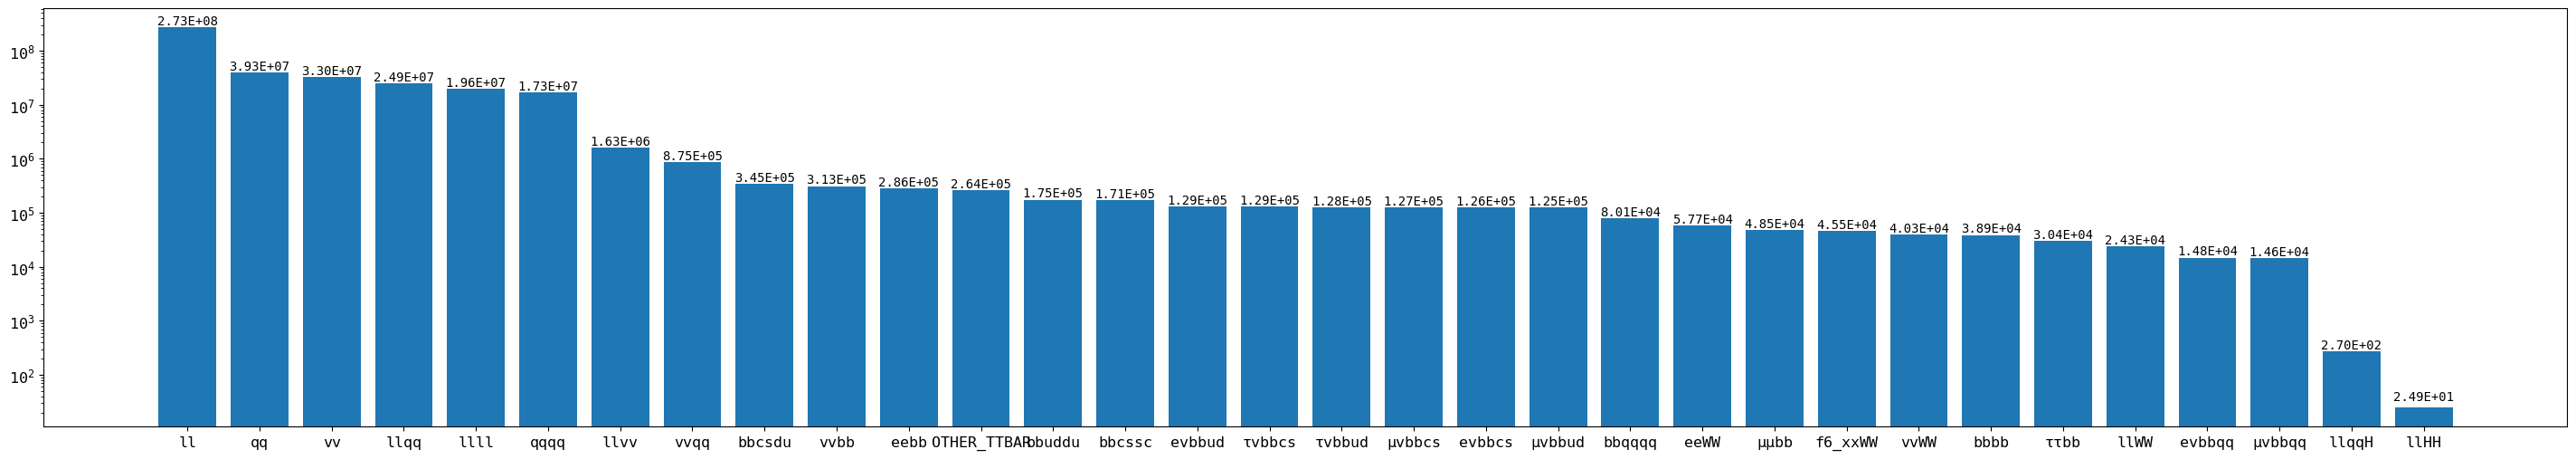

In [108]:
fig, ax = plt.subplots(figsize=(36, 6))

ax.bar(categories, counts)
ax.set_yscale('log')
rects = ax.patches

for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{count:.2E}', ha="center", va="bottom"
    )

plt.show()

In [117]:
module_reload('zhh')
from zhh import get_final_state_counts, final_state_stack

#fsc = get_final_state_counts(f'{REPO_ROOT}/PreselectionFinal/v1', [0,1], chunks_f)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fsc

In [119]:
fsc.nbytes

179125

In [70]:
def test(i):
    return np.sum(presel_results['ll_mh1'][presel_results['pid'] == i])

%timeit for i in range(len(processes)): test(i)

17.7 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


  0%|          | 0/10 [00:00<?, ?it/s]

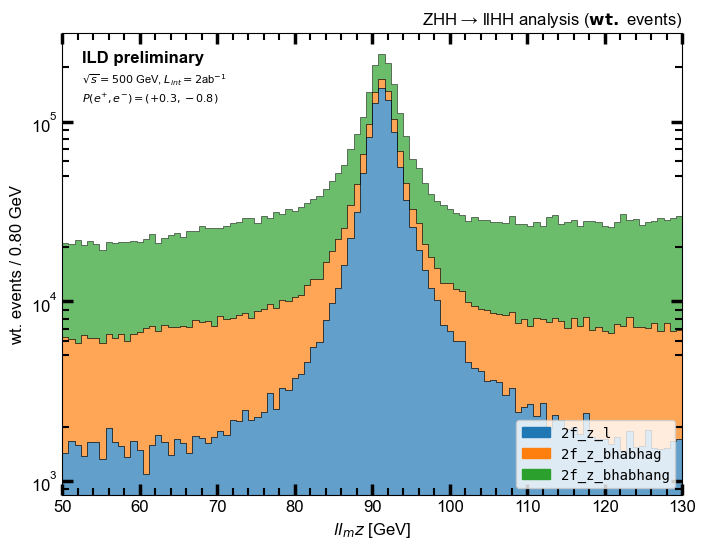

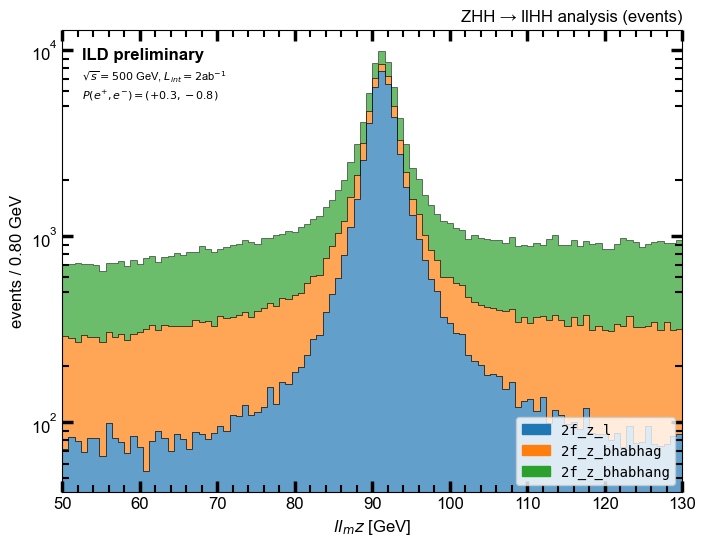

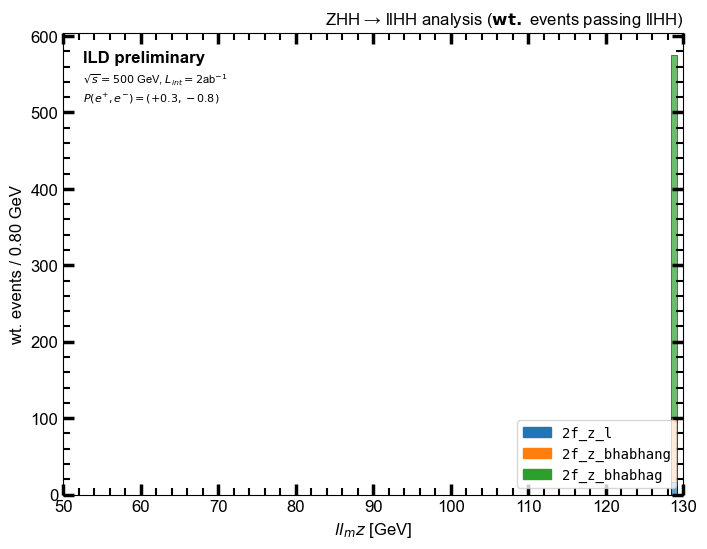

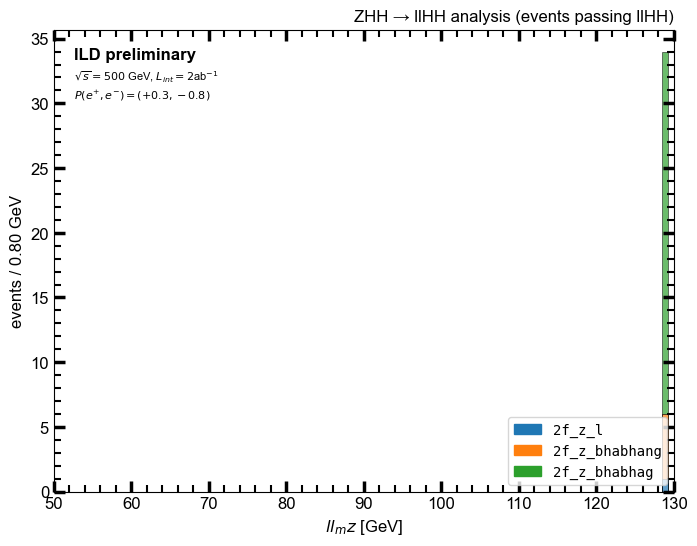

In [119]:
module_reload('zhh')
from zhh import plot_preselection_by_event_category

hypothesis = 'llHH'

plot_preselection_by_event_category(presel_results[presel_results['ll_mz'] > 0], processes, weights, hypothesis, [17], xlim=(50, 130),
                                    );

In [41]:
if False:
    presel_results = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_results.npy')
    weights = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_weights.npy')
else:
    np.save(f'{REPO_ROOT}/presel_results.npy', presel_results)
    np.save(f'{REPO_ROOT}/presel_weights.npy', weights)

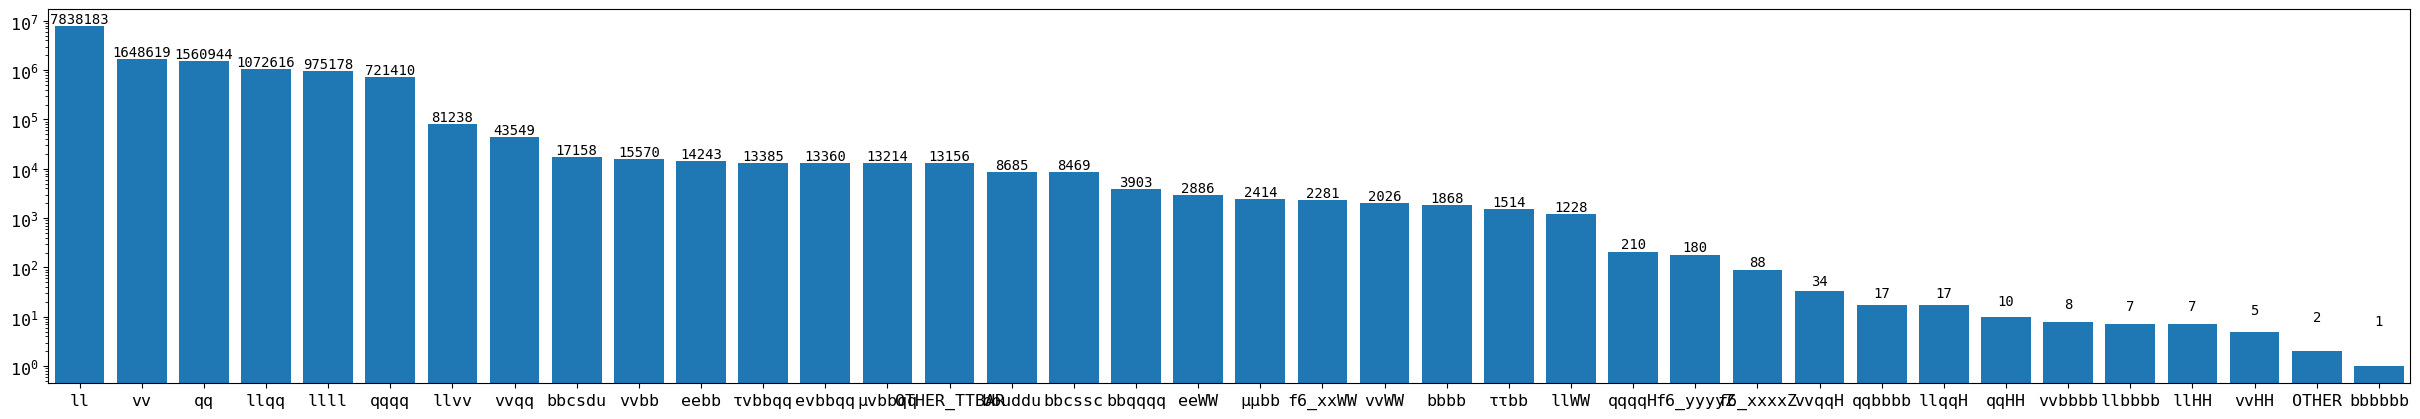

In [25]:
unq_cat, unq_counts = np.unique(presel_results['event_category'], return_counts=True)
mask = np.argsort(-unq_counts)

unq_cat = unq_cat[mask]
unq_counts = unq_counts[mask]
cat_counts = dict(zip(unq_cat, unq_counts))
unq_labels = category_arr['name'][np.isin(category_arr['evt_cat'], unq_cat)][mask]

fig, ax = plt.subplots(figsize=(24, 4))

ax.bar(unq_labels, unq_counts)
for rect, label in zip(ax.patches, unq_counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
ax.set_yscale('log')
ax.set_xlim(-0.5, len(unq_labels)-.5)
fig.set_tight_layout({"pad": .0})

In [29]:
unq_processes = np.unique(processes['process'])
expected_events = np.zeros(len(unq_processes), dtype=[('process', '<U60'), ('evt_expeceted', 'f')])
expected_events['process'] = unq_processes

for process_name in unq_processes:
    for process in processes[processes['process'] == process_name]:
        weight = weights['weight'][weights['pid'] == process['pid']][0]
        expected_events['evt_expeceted'][expected_events['process'] == process_name] += np.sum(chunks_f['chunk_size_factual'][chunks_f['proc_pol'] == process['proc_pol']])*weight
        
res = 0.
for process_name in ['e1e1hh', 'e2e2hh', 'e3e3hh']:
    res += expected_events['evt_expeceted'][expected_events['process'] == process_name][0]

print(f'expected llHH: {res:.2f} events')

expected llHH: 41.17 events


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

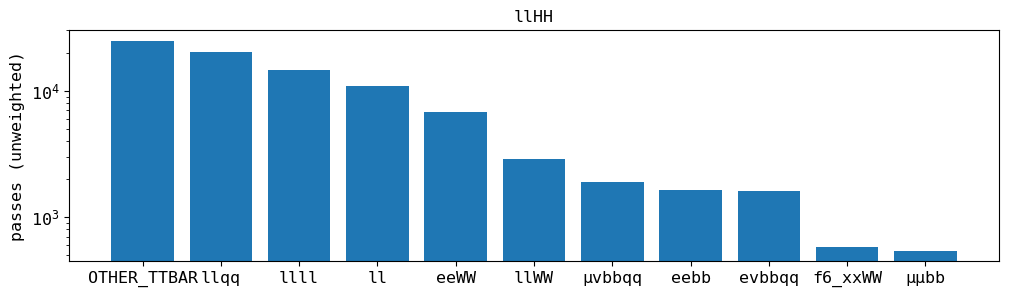

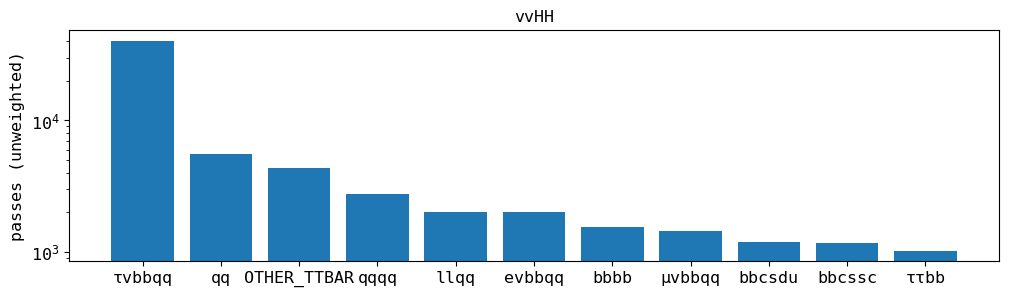

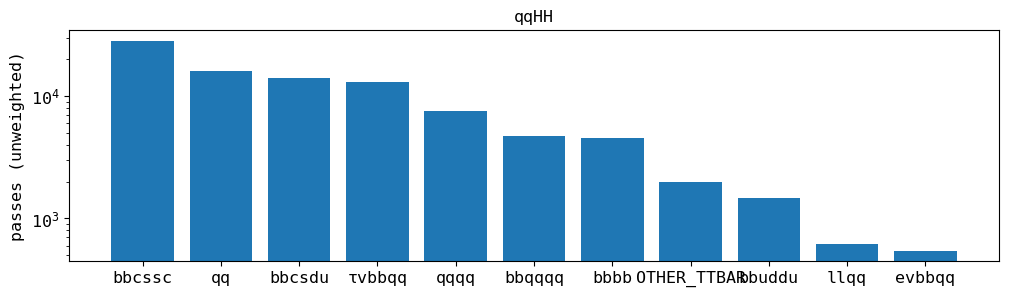

In [26]:
#event_categories = event_categories[event_categories != 0]
per_cat = {}

for presel in ['ll', 'vv', 'qq']:
    dtype = [
        ('category', 'i'),
        ('passes', 'f')
    ]
    passes_per_cat = np.zeros(len(unq_cat), dtype=dtype)
    passes_per_cat['category'] = unq_cat
    
    i = 0
    for category in tqdm(unq_cat):
        passes_per_cat[i]['category'] = category
        events = presel_results[presel_results['event_category'] == category]
        
        res = 0.
        for pid in np.unique(events['pid']):
            subset = events[events['pid'] == pid]
            res += np.sum(subset[f'{presel}_pass'] == 1) * weights['weight'][weights['pid'] == pid][0]
        
        passes_per_cat[i]['passes'] = res #/ cat_counts[category]
        
        i += 1
            
    per_cat[presel] = passes_per_cat
        
    sorted = passes_per_cat[np.argsort(-passes_per_cat['passes'])][:11]
    categories = []
    for s in sorted:
        categories.append(category_map_inv[s['category']])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(categories, sorted['passes'])
    ax.set_title(f'{presel}HH')
    ax.set_yscale('log')
    ax.set_ylabel('passes (unweighted)')

In [24]:
presel_results[presel_results['event_category'] == category_map['OTHER']]

array([(13569, 259, 0, 0, 0, 0, 0), (13570, 262, 0, 0, 0, 0, 0)],
      dtype=[('branch', '<i4'), ('pid', '<u2'), ('event', '<u4'), ('event_category', 'u1'), ('ll_pass', 'u1'), ('vv_pass', 'u1'), ('qq_pass', 'u1')])

In [27]:
pres = presel_results[presel_results['event_category'] == category_map['OTHER_TTBAR']]
subset = pres[['branch', 'event']]

In [29]:
branches = np.unique(subset['branch'])
print(len(branches))

1441
